In [1]:
import pandas as pd
import os
pwd = os.getcwd()
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import json
import requests


In [2]:
df_raw = pd.read_csv(pwd + "/data/activeltcoutbreak.csv")
df_raw.columns


Index(['Report_Data_Extracted', 'PHU_Num', 'PHU', 'LTC_Home', 'LTCH_Num',
       'City', 'Beds', 'Total_LTC_Resident_Cases', 'Total_LTC_Resident_Deaths',
       'Total_LTC_HCW_Cases'],
      dtype='object')

In [68]:
# First case of COVID-19 in Ontario, Canada was reported on January 25, 2020 (https://pmc.ncbi.nlm.nih.gov/articles/PMC9922963/#:~:text=In%20Ontario%2C%20Canada%2C%20the%20first,the%20first%20lockdown%20in%20Ontario.). 
# Therefore that is the start date for this analysis. 
reference_date = pd.to_datetime('2020-01-25')

#Due to challenges finding data for the first case, the assumption is made that any LTCH without 0 cases is considered the first "case"
# Similarly the first instance where LTCH deaths is not equal to 0 is considered the first death

Case_df = (
    df_raw[df_raw['Total_LTC_Resident_Cases'] != "0"]  # filter out rows without cases
    .assign(
        Report_Data_Extracted=pd.to_datetime(df_raw['Report_Data_Extracted']), # convert to date
        First_Case_Num_Days=lambda x: (x['Report_Data_Extracted'] - reference_date).dt.days #calculate difference in days
    )
    .sort_values(by='First_Case_Num_Days')  # sort by 'First_Case_Num_Days'
    .drop_duplicates(subset='LTCH_Num', keep='first')  # drop duplicates based on 'LTCH_Num'
    .loc[:, ['LTC_Home', 'First_Case_Num_Days']]  # column selection
)
Case_df

,LTC_Home,First_Case_Num_Days
0,"Albright Gardens Homes, Incorporated",90
106,Seven Oaks,90
105,Royal Terrace,90
104,Royal Rose Place,90
100,ReachView Village,90
...,...,...
82984,Highland Wood,1036
83811,EMO Health Centre,1046
89488,West Lake Terrace,1110
90556,Broadview Nursing Centre,1138


In [69]:
Death_df = (
    df_raw[df_raw['Total_LTC_Resident_Deaths'] != "0"]  # filter out rows without deaths
    .assign(
        Report_Data_Extracted=pd.to_datetime(df_raw['Report_Data_Extracted']), # convert to date
        First_Death_Num_Days=lambda x: (x['Report_Data_Extracted'] - reference_date).dt.days #calculate difference in days
    )
    .sort_values(by='First_Death_Num_Days')  # sort by 'First_Case_Num_Days'
    .drop_duplicates(subset='LTCH_Num', keep='first')  # drop duplicates based on 'LTCH_Num'
    .loc[:, ['LTC_Home', 'First_Death_Num_Days']]  # column selection
    # .drop_duplicates(subset='LTC_Home', keep='first') #dropping duplicates

)
Death_df



,LTC_Home,First_Death_Num_Days
1,Almonte Country Haven,90
108,Sherbourne Place,90
107,Shelburne Long Term Care Home,90
106,Seven Oaks,90
104,Royal Rose Place,90
...,...,...
90238,Extendicare Hamilton,1129
90503,Blue Water Rest Home,1137
90807,Hilltop Manor Nursing Home (Merrickville),1145
90862,Riverside Place,1146


In [94]:
Q1_df = pd.merge(Case_df, Death_df, on='LTC_Home', how='inner') 
Q1_df
# I choose inner join as to remove instances where no deaths occured at a LTCH. 
# The second half of the project is focused on risk factors associated with time to first COVID-19 death in LTCH, therefore, if no death occured at a LTCH, that LTCH should not be included in regression analysis.

,LTC_Home,First_Case_Num_Days,First_Death_Num_Days
0,"Albright Gardens Homes, Incorporated",90,377
1,Seven Oaks,90,90
2,Royal Terrace,90,935
3,Royal Rose Place,90,90
4,ReachView Village,90,95
...,...,...,...
521,Hanover Care Centre,993,1006
522,Chartwell Aylmer Long Term Care Residence,997,1013
523,The Bignucolo Residence,1001,1001
524,EMO Health Centre,1046,1059


In [95]:
df_paper = pd.read_excel(pwd + "/data/NH_data_.XLSX")
df_paper = df_paper.rename(columns={"LTCH": "LTC_Home"})
df_paper


,LTC_Home,PRIV_BEDS,SEMI_BEDS,THREE_BEDS,BASIC_BEDS,CONCARE_BED,RES_BED,INT_BED,ACCREDITATION,YEAR_RENO,...,Resident_death,Resident_deaths_per100beds,Had-outbreak_WAVE1,Local_incidence_WAVE1,Resident_deaths_WAVE1,Resident_deaths_per100beds_WAVE1,Had-outbreak_WAVE2,Local_incidence_WAVE2,Resident_deaths_WAVE2,Resident_deaths_per100beds_WAVE2
0,AFTON PARK PLACE LONG TERM CARE COMMUNITY,76.0,52.0,0.0,0.0,0,0,0,0,0,...,0,0.0,YES,"Medium (150-299 cases per 100,000 before Sept....",0,0.0,YES,Medium local incidence,0,0.0
1,"ALBRIGHT GARDENS HOMES, INCORPORATED",167.0,64.0,0.0,0.0,0,0,0,0,0,...,1,0.4,YES,"Medium (150-299 cases per 100,000 before Sept....",0,0.0,YES,Medium local incidence,1,0.4
2,ALEXANDER PLACE,80.0,48.0,0.0,0.0,0,2,0,1,0,...,1,0.8,YES,"Medium (150-299 cases per 100,000 before Sept....",0,0.0,YES,Medium local incidence,1,0.8
3,ALGOMA MANOR NURSING HOME,48.0,48.0,0.0,0.0,1,0,0,1,0,...,0,0.0,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",0,0.0,NO,Low local incidence,0,0.0
4,ALGONQUIN NURSING HOME,1.0,24.0,0.0,48.0,0,1,1,1,1,...,0,0.0,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",0,0.0,YES,Low local incidence,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,YEE HONG CENTRE - MISSISSAUGA,88.0,112.0,0.0,0.0,0,0,0,1,0,...,1,0.5,NO,"High (300+ cases per 100,000 before Sept. 1, 2...",0,0.0,YES,High local incidence,1,0.5
623,YEE HONG CENTRE - SCARBOROUGH FINCH,110.0,140.0,0.0,0.0,0,1,0,1,0,...,0,0.0,YES,"High (300+ cases per 100,000 before Sept. 1, 2...",0,0.0,YES,High local incidence,0,0.0
624,YEE HONG CENTRE - SCARBOROUGH MCNICOLL,67.0,88.0,0.0,0.0,0,0,0,1,0,...,0,0.0,YES,"High (300+ cases per 100,000 before Sept. 1, 2...",0,0.0,YES,High local incidence,0,0.0
625,YORK REGION MAPLE HEALTH CENTRE,68.0,32.0,0.0,0.0,15,3,0,1,0,...,1,1.0,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",0,0.0,YES,High local incidence,1,1.0


In [96]:
# Clean the text columns
Q1_df['LTC_Home'] = Q1_df['LTC_Home'].str.strip().str.lower()
df_paper['LTC_Home'] = df_paper['LTC_Home'].str.strip().str.lower()

#Merging
Q2_df = pd.merge(Q1_df, df_paper, on='LTC_Home', how='left')
Q2_df


,LTC_Home,First_Case_Num_Days,First_Death_Num_Days,PRIV_BEDS,SEMI_BEDS,THREE_BEDS,BASIC_BEDS,CONCARE_BED,RES_BED,INT_BED,...,Resident_death,Resident_deaths_per100beds,Had-outbreak_WAVE1,Local_incidence_WAVE1,Resident_deaths_WAVE1,Resident_deaths_per100beds_WAVE1,Had-outbreak_WAVE2,Local_incidence_WAVE2,Resident_deaths_WAVE2,Resident_deaths_per100beds_WAVE2
0,"albright gardens homes, incorporated",90,377,167.0000,64.000000,0.000000,0.000000,0.0,0.0,0.0,...,1.0,0.4,YES,"Medium (150-299 cases per 100,000 before Sept....",0.0,0.0,YES,Medium local incidence,1.0,0.4
1,seven oaks,90,90,137.0000,112.000000,0.000000,0.000000,17.0,2.0,0.0,...,41.0,16.5,YES,"High (300+ cases per 100,000 before Sept. 1, 2...",41.0,16.5,YES,High local incidence,0.0,0.0
2,royal terrace,90,935,61.8663,50.106115,0.000000,14.008993,0.0,0.0,0.0,...,0.0,0.0,YES,"Medium (150-299 cases per 100,000 before Sept....",0.0,0.0,YES,Medium local incidence,0.0,0.0
3,royal rose place,90,90,58.0000,38.000000,0.000000,0.000000,0.0,0.0,0.0,...,20.0,20.8,YES,"Medium (150-299 cases per 100,000 before Sept....",20.0,20.8,YES,Medium local incidence,0.0,0.0
4,reachview village,90,95,3.0000,24.000000,3.000000,72.000000,0.0,0.0,0.0,...,17.0,17.0,YES,"Medium (150-299 cases per 100,000 before Sept....",17.0,17.0,YES,Medium local incidence,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,hanover care centre,993,1006,6.0000,12.000000,0.000000,24.000000,0.0,0.0,0.0,...,0.0,0.0,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",0.0,0.0,NO,Low local incidence,0.0,0.0
522,chartwell aylmer long term care residence,997,1013,61.8663,0.000000,0.000000,14.008993,0.0,0.0,0.0,...,0.0,0.0,NO,"Medium (150-299 cases per 100,000 before Sept....",0.0,0.0,YES,Medium local incidence,0.0,0.0
523,the bignucolo residence,1001,1001,61.8663,50.106115,1.657468,14.008993,0.0,2.0,0.0,...,0.0,0.0,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",0.0,0.0,NO,Low local incidence,0.0,0.0
524,emo health centre,1046,1059,61.8663,50.106115,1.657468,14.008993,0.0,0.0,0.0,...,0.0,0.0,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",0.0,0.0,NO,Low local incidence,0.0,0.0


In [97]:
# #Replacing Time to Death missing values, this is because 15.29% of LTCH did not have a death
# Q2_df['First_Death_Num_Days'] = Q2_df['First_Death_Num_Days'].interpolate(method='linear')

Q2_missing = Q2_df.isna().sum() / len(Q2_df) * 100 
# <4% missingness in all columns upon merging the second dataset, I will leave it as is
print(Q2_missing.to_string())



LTC_Home                            0.000000
First_Case_Num_Days                 0.000000
First_Death_Num_Days                0.000000
PRIV_BEDS                           3.802281
SEMI_BEDS                           3.802281
THREE_BEDS                          3.802281
BASIC_BEDS                          3.802281
CONCARE_BED                         3.802281
RES_BED                             3.802281
INT_BED                             3.802281
ACCREDITATION                       3.802281
YEAR_RENO                           3.802281
CON_Y                               3.802281
Total_Beds                          3.802281
PER_FEM_LTCR                        3.802281
PER_LTCR<65                         3.802281
PER_LTCR>85                         3.802281
PER_LTCR_DEMENTIA                   3.802281
PER_LTCR_CHF                        3.802281
PR_ANTIP_MED                        3.802281
PR_PREUL                            3.802281
PR_FELL                             3.802281
PR_PHYS_RE

In [98]:

duplicates = Q2_df[Q2_df.duplicated(keep=False)] 
duplicates # no duplicates shown

,LTC_Home,First_Case_Num_Days,First_Death_Num_Days,PRIV_BEDS,SEMI_BEDS,THREE_BEDS,BASIC_BEDS,CONCARE_BED,RES_BED,INT_BED,...,Resident_death,Resident_deaths_per100beds,Had-outbreak_WAVE1,Local_incidence_WAVE1,Resident_deaths_WAVE1,Resident_deaths_per100beds_WAVE1,Had-outbreak_WAVE2,Local_incidence_WAVE2,Resident_deaths_WAVE2,Resident_deaths_per100beds_WAVE2


In [99]:
# Select only the continuous columns for centering and standardizing
continuous_cols = Q2_df.select_dtypes(include=['float64', 'int64'])

# Centering and standardizing: subtract the mean and divide by the standard deviation
Q2_df_centered_standardized = (continuous_cols - continuous_cols.mean()) / continuous_cols.std()

# Replace the original numerical columns with the centered and standardized versions
Q2_df[continuous_cols.columns] = Q2_df_centered_standardized

Q2_df

,LTC_Home,First_Case_Num_Days,First_Death_Num_Days,PRIV_BEDS,SEMI_BEDS,THREE_BEDS,BASIC_BEDS,CONCARE_BED,RES_BED,INT_BED,...,Resident_death,Resident_deaths_per100beds,Had-outbreak_WAVE1,Local_incidence_WAVE1,Resident_deaths_WAVE1,Resident_deaths_per100beds_WAVE1,Had-outbreak_WAVE2,Local_incidence_WAVE2,Resident_deaths_WAVE2,Resident_deaths_per100beds_WAVE2
0,"albright gardens homes, incorporated",-1.033283,-0.514579,1.710767,0.234690,-0.228945,-0.539937,-0.227053,-0.459654,-0.155958,...,-0.464718,-0.544325,YES,"Medium (150-299 cases per 100,000 before Sept....",-0.332422,-0.354820,YES,Medium local incidence,-0.287695,-0.365217
1,seven oaks,-1.033283,-1.364071,1.207604,1.276505,-0.228945,-0.539937,3.279430,1.854622,-0.155958,...,2.614131,1.353637,YES,"High (300+ cases per 100,000 before Sept. 1, 2...",3.674798,2.130202,YES,High local incidence,-0.396820,-0.429826
2,royal terrace,-1.033283,1.137048,-0.052545,-0.066869,-0.228945,-0.020161,-0.227053,-0.459654,-0.155958,...,-0.541689,-0.591480,YES,"Medium (150-299 cases per 100,000 before Sept....",-0.332422,-0.354820,YES,Medium local incidence,-0.396820,-0.429826
3,royal rose place,-1.033283,-1.364071,-0.117391,-0.329626,-0.228945,-0.539937,-0.227053,-0.459654,-0.155958,...,0.997736,1.860547,YES,"Medium (150-299 cases per 100,000 before Sept....",1.622319,2.777814,YES,Medium local incidence,-0.396820,-0.429826
4,reachview village,-1.033283,-1.349272,-1.039855,-0.633488,0.169778,2.131481,-0.227053,-0.459654,-0.155958,...,0.766822,1.412580,YES,"Medium (150-299 cases per 100,000 before Sept....",1.329108,2.205506,YES,Medium local incidence,-0.396820,-0.429826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,hanover care centre,2.112503,1.347201,-0.989539,-0.893942,-0.228945,0.350535,-0.227053,-0.459654,-0.155958,...,-0.541689,-0.591480,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",-0.332422,-0.354820,NO,Low local incidence,-0.396820,-0.429826
522,chartwell aylmer long term care residence,2.126438,1.367920,-0.052545,-1.154395,-0.228945,-0.020161,-0.227053,-0.459654,-0.155958,...,-0.541689,-0.591480,NO,"Medium (150-299 cases per 100,000 before Sept....",-0.332422,-0.354820,YES,Medium local incidence,-0.396820,-0.429826
523,the bignucolo residence,2.140373,1.332402,-0.052545,-0.066869,-0.008655,-0.020161,-0.227053,1.854622,-0.155958,...,-0.541689,-0.591480,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",-0.332422,-0.354820,NO,Low local incidence,-0.396820,-0.429826
524,emo health centre,2.297139,1.504076,-0.052545,-0.066869,-0.008655,-0.020161,-0.227053,-0.459654,-0.155958,...,-0.541689,-0.591480,NO,"Low (<150 cases per 100,000 before Sept. 1, 2020)",-0.332422,-0.354820,NO,Low local incidence,-0.396820,-0.429826


In [104]:
#Q3
Q3_df = Q2_df
x = Q3_df.drop(["LTC_Home", "First_Death_Num_Days"], axis=1)
# Keep only numerical columns
x = x.select_dtypes(include=['float64', 'int64'])
x = x.fillna(x.interpolate(method='linear')) #simply replace missing values (<4% missing)


y = Q3_df["First_Death_Num_Days"]
x.head()

,First_Case_Num_Days,PRIV_BEDS,SEMI_BEDS,THREE_BEDS,BASIC_BEDS,CONCARE_BED,RES_BED,INT_BED,ACCREDITATION,YEAR_RENO,...,B_Beds,C_Beds,D_Upgrade_Beds,ELDCAP_Beds,Resident_death,Resident_deaths_per100beds,Resident_deaths_WAVE1,Resident_deaths_per100beds_WAVE1,Resident_deaths_WAVE2,Resident_deaths_per100beds_WAVE2
0,-1.033283,1.710767,0.234690,-0.228945,-0.539937,-0.227053,-0.459654,-0.155958,-1.831782,-0.560058,...,-0.288329,-0.616757,-0.129924,-0.087652,-0.464718,-0.544325,-0.332422,-0.354820,-0.287695,-0.365217
1,-1.033283,1.207604,1.276505,-0.228945,-0.539937,3.279430,1.854622,-0.155958,0.544838,-0.560058,...,-0.288329,3.013937,-0.129924,-0.087652,2.614131,1.353637,3.674798,2.130202,-0.396820,-0.429826
2,-1.033283,-0.052545,-0.066869,-0.228945,-0.020161,-0.227053,-0.459654,-0.155958,-1.831782,-0.560058,...,1.694417,-0.616757,-0.129924,-0.087652,-0.541689,-0.591480,-0.332422,-0.354820,-0.396820,-0.429826
3,-1.033283,-0.117391,-0.329626,-0.228945,-0.539937,-0.227053,-0.459654,-0.155958,-1.831782,-0.560058,...,-0.288329,-0.616757,-0.129924,-0.087652,0.997736,1.860547,1.622319,2.777814,-0.396820,-0.429826
4,-1.033283,-1.039855,-0.633488,0.169778,2.131481,-0.227053,-0.459654,-0.155958,0.544838,1.782002,...,-0.288329,0.841353,-0.129924,-0.087652,0.766822,1.412580,1.329108,2.205506,-0.396820,-0.429826


In [105]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)

vif_data = pd.DataFrame()
vif_data["feature"] = x.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i) 
                   for i in range(len(x.columns))]

print(vif_data) # 11 features with VIF > 10

                             feature           VIF
0                First_Case_Num_Days  1.634852e+00
1                          PRIV_BEDS  7.034823e+00
2                          SEMI_BEDS  4.346301e+00
3                         THREE_BEDS  1.312492e+00
4                         BASIC_BEDS  2.676835e+00
5                        CONCARE_BED  1.316245e+00
6                            RES_BED  1.347006e+00
7                            INT_BED  1.627996e+00
8                      ACCREDITATION  1.198969e+00
9                          YEAR_RENO  1.343603e+00
10                             CON_Y  1.584489e+00
11                        Total_Beds  1.965449e+02
12                      PER_FEM_LTCR  1.523612e+00
13                       PER_LTCR<65  2.807858e+00
14                       PER_LTCR>85  3.024565e+00
15                 PER_LTCR_DEMENTIA  1.588648e+00
16                      PER_LTCR_CHF  1.209370e+00
17                      PR_ANTIP_MED  1.351887e+00
18                          PR_

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [108]:
vif_data_new = vif_data.loc[vif_data.VIF > 10]
vif_data_new

11

In [107]:
# Calculate the correlation matrix
low_vif_features = vif_data[vif_data['VIF'] < 10]['feature'].tolist()

corr_matrix = Q3_df[low_vif_features].corr()
corr_matrix

,Total_Beds,New_D_Retrofit_Beds,A_Beds,B_Beds,C_Beds,Resident_death,Resident_deaths_per100beds,Resident_deaths_WAVE1,Resident_deaths_per100beds_WAVE1,Resident_deaths_WAVE2,Resident_deaths_per100beds_WAVE2
Total_Beds,1.000000,0.513078,0.256802,0.067503,0.217064,0.297159,0.048675,0.222104,0.048599,0.173312,0.014465
New_D_Retrofit_Beds,0.513078,1.000000,-0.164780,-0.184790,-0.476397,-0.043245,-0.129575,-0.037691,-0.079695,-0.019227,-0.092140
A_Beds,0.256802,-0.164780,1.000000,-0.046843,-0.143099,-0.060443,-0.078175,-0.054032,-0.054752,-0.025365,-0.048248
B_Beds,0.067503,-0.184790,-0.046843,1.000000,-0.154648,0.014573,-0.028195,0.040580,-0.011655,-0.024647,-0.026396
C_Beds,0.217064,-0.476397,-0.143099,-0.154648,1.000000,0.392041,0.272287,0.296239,0.193879,0.225057,0.165162
Resident_death,0.297159,-0.043245,-0.060443,0.014573,0.392041,1.000000,0.863484,0.712793,0.604697,0.621896,0.534297
Resident_deaths_per100beds,0.048675,-0.129575,-0.078175,-0.028195,0.272287,0.863484,1.000000,0.595543,0.689814,0.559263,0.630157
Resident_deaths_WAVE1,0.222104,-0.037691,-0.054032,0.040580,0.296239,0.712793,0.595543,1.000000,0.872112,-0.105963,-0.119530
Resident_deaths_per100beds_WAVE1,0.048599,-0.079695,-0.054752,-0.011655,0.193879,0.604697,0.689814,0.872112,1.000000,-0.116426,-0.127459
Resident_deaths_WAVE2,0.173312,-0.019227,-0.025365,-0.024647,0.225057,0.621896,0.559263,-0.105963,-0.116426,1.000000,0.890955


In [79]:
# List of columns to drop
columns_to_drop = [
    'Total_Beds', 'New_D_Retrofit_Beds', 'A_Beds', 'B_Beds', 'C_Beds',
    'Resident_death', 'Resident_deaths_per100beds', 'Resident_deaths_WAVE1',
    'Resident_deaths_per100beds_WAVE1', 'Resident_deaths_WAVE2', 'Resident_deaths_per100beds_WAVE2'
]

x = x.drop(columns=columns_to_drop)
y = Q3_df["First_Death_Num_Days"]


In [80]:

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)

vif_data = pd.DataFrame()
vif_data["feature"] = x.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i) 
                   for i in range(len(x.columns))]

print(vif_data)

#All have extremely low VIF


                     feature       VIF
0                  PRIV_BEDS  1.778793
1                  SEMI_BEDS  1.423800
2                 THREE_BEDS  1.178966
3                 BASIC_BEDS  1.428743
4                CONCARE_BED  1.272347
5                    RES_BED  1.268283
6                    INT_BED  1.139411
7              ACCREDITATION  1.130690
8                  YEAR_RENO  1.290046
9                      CON_Y  1.423572
10              PER_FEM_LTCR  1.484263
11               PER_LTCR<65  2.424479
12               PER_LTCR>85  2.697450
13         PER_LTCR_DEMENTIA  1.455011
14              PER_LTCR_CHF  1.111901
15              PR_ANTIP_MED  1.228776
16                  PR_PREUL  1.345442
17                   PR_FELL  1.401524
18               PR_PHYS_RES  1.247793
19               PR_WRS_DEPR  1.752530
20                   PR_PAIN  1.440435
21               PR_IMPRV_FX  1.291572
22                 PR_WRS_FX  1.389939
23               PR_WRS_PAIN  1.752978
24      Funded_CMI_2020_2

<AxesSubplot: >

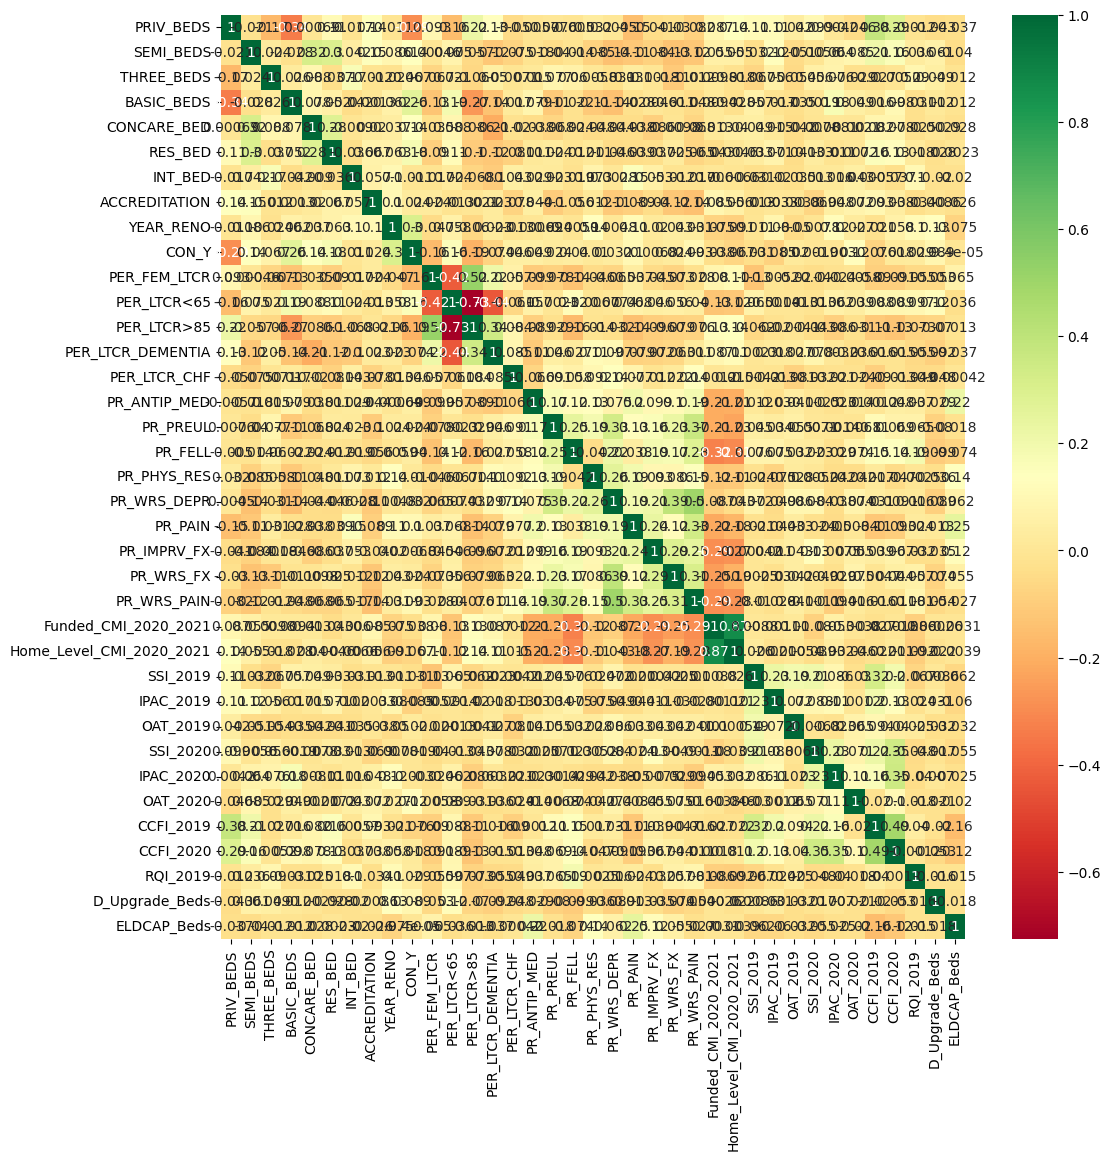

In [81]:
corrmat = x.corr()
feature_ind = corrmat.index
plt.figure(figsize=(12,12))
sns.heatmap(Q3_df[feature_ind].corr(), annot=True, cmap= "RdYlGn")

#All showing low correlation <0.7

In [82]:
#Backward Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Initialize the model and the backward feature selector
backward_selector = SequentialFeatureSelector(
    model,
    n_features_to_select='auto',
    direction='backward',
    scoring='r2',
    cv=5
)

# Fit the backward selector to the data
backward_selector.fit(x_train, y_train)

# Get selected features
selected_features_backward = x.columns[backward_selector.get_support()]
print("Selected features with backward selection:", selected_features_backward)

Selected features with backward selection: Index(['PRIV_BEDS', 'SEMI_BEDS', 'THREE_BEDS', 'BASIC_BEDS', 'INT_BED',
       'ACCREDITATION', 'PER_LTCR>85', 'PER_LTCR_CHF', 'PR_PHYS_RES',
       'PR_PAIN', 'PR_IMPRV_FX', 'PR_WRS_FX', 'Home_Level_CMI_2020_2021',
       'SSI_2019', 'IPAC_2019', 'IPAC_2020', 'RQI_2019', 'D_Upgrade_Beds',
       'ELDCAP_Beds'],
      dtype='object')


In [83]:
# Initialize the model and the forward feature selector
model = LinearRegression()
forward_selector = SequentialFeatureSelector(
    model,
    n_features_to_select='auto',
    direction='forward',
    scoring='r2',
    cv=5
)

# Fit the forward selector to the data
forward_selector.fit(x_train, y_train)

# Get selected features
selected_features_forward = x.columns[forward_selector.get_support()]
print("Selected features with forward selection:", selected_features_forward)

Selected features with forward selection: Index(['PRIV_BEDS', 'SEMI_BEDS', 'BASIC_BEDS', 'ACCREDITATION', 'PER_LTCR>85',
       'PER_LTCR_CHF', 'PR_ANTIP_MED', 'PR_WRS_DEPR', 'PR_PAIN', 'PR_IMPRV_FX',
       'PR_WRS_FX', 'Home_Level_CMI_2020_2021', 'IPAC_2019', 'SSI_2020',
       'IPAC_2020', 'RQI_2019', 'D_Upgrade_Beds', 'ELDCAP_Beds'],
      dtype='object')


In [84]:
# Define backward and forward selection features
backward_features = ['SEMI_BEDS', 'BASIC_BEDS', 'RES_BED', 'ACCREDITATION', 'CON_Y',
                     'PER_LTCR<65', 'PER_LTCR>85', 'PER_LTCR_CHF', 'PR_WRS_DEPR', 'PR_PAIN',
                     'PR_IMPRV_FX', 'PR_WRS_FX', 'Home_Level_CMI_2020_2021', 'IPAC_2019',
                     'IPAC_2020', 'CCFI_2019', 'CCFI_2020', 'RQI_2019', 'ELDCAP_Beds']

forward_features = ['SEMI_BEDS', 'BASIC_BEDS', 'RES_BED', 'ACCREDITATION', 'CON_Y',
                    'PER_LTCR<65', 'PER_LTCR>85', 'PER_LTCR_CHF', 'PR_WRS_DEPR', 'PR_PAIN',
                    'PR_IMPRV_FX', 'Home_Level_CMI_2020_2021', 'IPAC_2019',
                    'IPAC_2020', 'CCFI_2019', 'CCFI_2020', 'RQI_2019', 'ELDCAP_Beds']

# Common features
common_features = list(set(backward_features).intersection(forward_features))
print("Common Features:", common_features)


Common Features: ['CON_Y', 'Home_Level_CMI_2020_2021', 'SEMI_BEDS', 'RES_BED', 'PR_IMPRV_FX', 'PER_LTCR>85', 'BASIC_BEDS', 'PR_PAIN', 'RQI_2019', 'PR_WRS_DEPR', 'CCFI_2020', 'ACCREDITATION', 'ELDCAP_Beds', 'IPAC_2019', 'IPAC_2020', 'CCFI_2019', 'PER_LTCR<65', 'PER_LTCR_CHF']


In [85]:
#Q4
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
model = LinearRegression()
model.fit(x_train, y_train)

pd.DataFrame(model.coef_, x.columns, columns=["Coeff"])

,Coeff
PRIV_BEDS,-0.136243
SEMI_BEDS,-0.164125
THREE_BEDS,-0.009554
BASIC_BEDS,-0.136634
CONCARE_BED,-0.024567
RES_BED,-0.047626
INT_BED,0.007235
ACCREDITATION,-0.132541
YEAR_RENO,-0.013759
CON_Y,0.032500
